# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

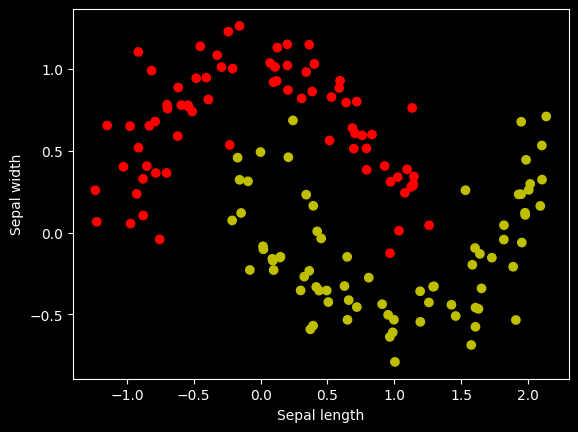

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [16]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0109)


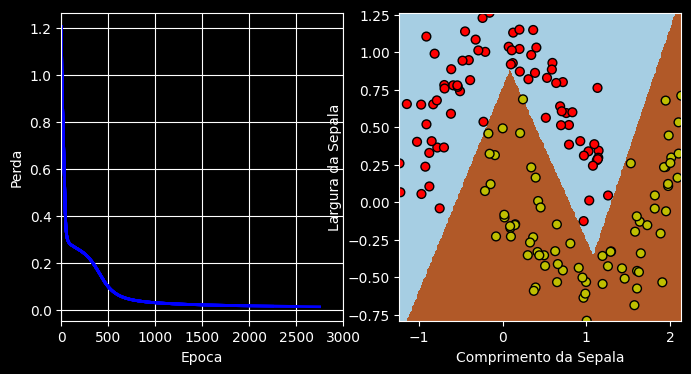

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 2.9307,  0.3236],
        [ 2.5770,  0.2861],
        [ 1.5405, -0.8447],
        [-0.6478,  0.9867],
        [-0.3803, -0.2311]])
dense.0.bias    torch.Size([5])
tensor([-0.5408, -2.6951,  1.3847,  1.1622, -0.6449])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.0377,  0.1091, -0.3714, -0.3295,  0.1109],
        [ 0.2676, -0.1876, -0.2152,  0.5508,  0.3965],
        [ 1.7027, -2.3693, -0.5298,  1.3207, -0.3867],
        [-2.3610,  2.7354,  2.0825, -0.4429, -0.1901],
        [-0.3171,  0.0283, -0.0060, -0.1803, -0.3947]])
dense.2.bias    torch.Size([5])
tensor([-0.2475,  0.8459,  0.1320,  1.1650, -0.3406])
dense.4.weight  torch.Size([3, 5])
tensor([[-0.2210,  0.4389,  2.6571, -2.6894,  0.0979],
        [-0.3961, -0.2361, -1.7910,  3.3303, -0.0651],
        [ 0.4252, -0.9142, -0.4239, -0.6765,  0.0033]])
dense.4.bias    torch.Size([3])
tensor([ 0.7170,  0.8967, -1.0351])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.

Com a alteração da rede, podemos observar os seguintes pontos:

1. **Aumento do número de neurônios e camadas**:
    - A inclusão de mais neurônios e camadas permite que a rede aprenda representações mais complexas dos dados. Isso pode melhorar a capacidade da rede de capturar padrões não lineares, especialmente em datasets mais complexos.

2. **Impacto no desempenho**:
    - O aumento da complexidade da rede pode levar a uma melhora na precisão do modelo, como observado no aumento da acurácia para 100% no conjunto de treinamento. Isso indica que a rede conseguiu separar perfeitamente as classes no espaço de entrada.

3. **Risco de overfitting**:
    - Redes mais complexas têm maior capacidade de modelar os dados de treinamento, mas isso também pode levar ao overfitting, onde o modelo se ajusta muito bem aos dados de treinamento, mas não generaliza bem para novos dados. É importante avaliar o desempenho em um conjunto de validação ou teste para verificar se o modelo está generalizando bem.

4. **Tempo de treinamento**:
    - Redes maiores podem exigir mais tempo de treinamento devido ao aumento no número de parâmetros. Isso deve ser considerado ao projetar a arquitetura da rede.

5. **Escolha da arquitetura**:
    - A escolha da arquitetura ideal depende do problema e do dataset. Redes mais simples podem ser suficientes para problemas mais simples, enquanto redes mais complexas são necessárias para problemas mais desafiadores.

Conclusão: A alteração da rede resultou em um modelo mais poderoso, capaz de aprender melhor os padrões do dataset. No entanto, é essencial monitorar o desempenho em dados não vistos para garantir que o modelo não esteja superajustado.

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 6),
            nn.ReLU(),
            nn.Linear(6, 8),
            nn.ReLU(),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x

# Atualizando o modelo
model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)


In [19]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.0026)


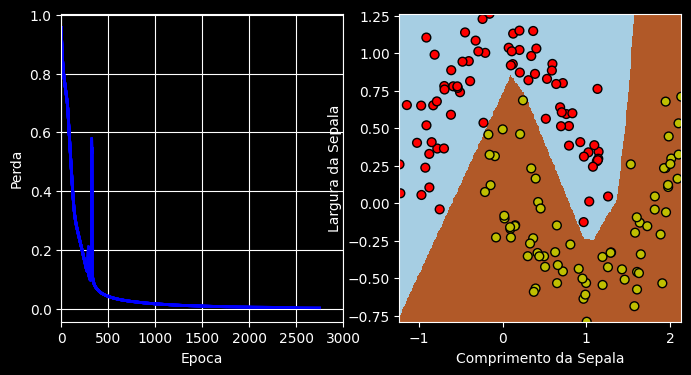

In [20]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

In [21]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 6),
            nn.Sigmoid(),
            nn.Linear(6, 8),
            nn.Sigmoid(),
            nn.Linear(8, 5),
            nn.Sigmoid(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x

# Atualizando o modelo
model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)


In [22]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.6304)


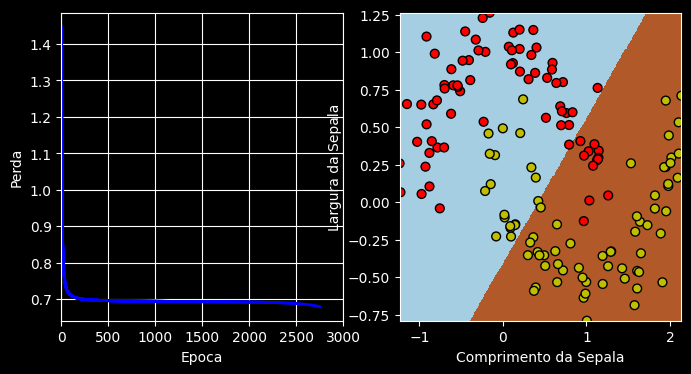

In [23]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Ao substituir a função de ativação **ReLU** pela **Sigmoid** nas camadas da rede neural, ocorreram as seguintes mudanças:

1. **Diferença no comportamento da ativação**:
    - A função **ReLU** (Rectified Linear Unit) é linear para valores positivos e zera valores negativos, o que ajuda a evitar o problema de gradientes desaparecendo e acelera o treinamento.
    - A função **Sigmoid** mapeia os valores para o intervalo (0, 1), o que pode causar saturação para valores muito altos ou muito baixos, resultando em gradientes pequenos e treinamento mais lento.

2. **Impacto no treinamento**:
    - Com a **Sigmoid**, o treinamento pode ser mais lento devido à saturação da função de ativação, especialmente em redes profundas.
    - A perda final (loss) foi maior em comparação com a versão com **ReLU**, indicando que a rede teve mais dificuldade em ajustar os pesos para minimizar a perda.

3. **Desempenho do modelo**:
    - A precisão do modelo pode ser afetada negativamente, pois a **Sigmoid** pode limitar a capacidade da rede de aprender representações complexas dos dados.

4. **Conclusão**:
    - A troca para **Sigmoid** demonstrou que a escolha da função de ativação impacta diretamente o desempenho e a eficiência do treinamento. A **ReLU** é geralmente preferida em redes profundas devido à sua simplicidade e eficiência.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?  
r = Quando não se utiliza ativação não linear entre camadas em uma rede neural, os seguintes problemas podem ocorrer:

1. **Comportamento linear**:
    - Sem funções de ativação não lineares, a rede neural se torna essencialmente uma combinação linear de suas entradas, independentemente do número de camadas. Isso significa que a rede não consegue aprender relações não lineares nos dados, limitando sua capacidade de modelar problemas complexos.

2. **Perda de profundidade efetiva**:
    - A profundidade da rede (número de camadas) não adiciona valor significativo, pois a composição de várias transformações lineares ainda resulta em uma transformação linear. Assim, uma rede profunda sem não linearidades é equivalente a uma única camada linear.

3. **Redução da capacidade de aprendizado**:
    - A ausência de não linearidades impede que a rede capture padrões complexos nos dados, reduzindo sua capacidade de generalizar para novos exemplos.

4. **Impacto no desempenho**:
    - O modelo pode apresentar desempenho ruim em tarefas que exigem a modelagem de relações não lineares, como classificação de dados complexos ou reconhecimento de padrões.

Conclusão: A utilização de funções de ativação não lineares, como ReLU, Sigmoid ou Tanh, é essencial para que a rede neural possa aprender e representar relações não lineares nos dados, aproveitando ao máximo sua profundidade e complexidade.

## Principais aprendizados

1. **Manipulação de Dados**:
    - Carregamento e pré-processamento de datasets (e.g., Iris, moon, circles, blobs).
    - Normalização e visualização de dados com gráficos de dispersão.

2. **Construção de Redes Neurais**:
    - Definição de arquiteturas de redes neurais no PyTorch.
    - Uso de camadas densas e funções de ativação não lineares (ReLU, Sigmoid).
    - Impacto de diferentes arquiteturas e funções de ativação no desempenho.

3. **Treinamento de Redes Neurais**:
    - Configuração de otimizadores (e.g., SGD) e funções de perda (e.g., CrossEntropyLoss).
    - Implementação de loops de treinamento com retropropagação.
    - Monitoramento da perda durante o treinamento.

4. **Visualização de Resultados**:
    - Criação de visualizações dinâmicas para observar a evolução da fronteira de decisão.
    - Avaliação do modelo com métricas como acurácia e matriz de confusão.

5. **Experimentação**:
    - Alteração de hiperparâmetros (e.g., taxa de aprendizado, número de épocas).
    - Modificação da arquitetura da rede para explorar diferentes configurações.
    - Comparação entre funções de ativação (ReLU vs. Sigmoid) e seus impactos.

6. **Conceitos Fundamentais**:
    - Importância de funções de ativação não lineares para aprendizado de padrões complexos.
    - Riscos de overfitting ao aumentar a complexidade da rede.
    - Diferença entre redes lineares e não lineares.

7. **Ferramentas e Frameworks**:
    - Uso de bibliotecas como PyTorch, NumPy, Matplotlib e Scikit-learn.
    - Integração de visualizações interativas no Jupyter Notebook.